In [1]:
import networkx as nx
import numpy as np

Number of nodes: 34
Number of edges: 78
Nodes: [(0, {'club': 'Mr. Hi'}), (1, {'club': 'Mr. Hi'}), (2, {'club': 'Mr. Hi'}), (3, {'club': 'Mr. Hi'}), (4, {'club': 'Mr. Hi'}), (5, {'club': 'Mr. Hi'}), (6, {'club': 'Mr. Hi'}), (7, {'club': 'Mr. Hi'}), (8, {'club': 'Mr. Hi'}), (9, {'club': 'Officer'}), (10, {'club': 'Mr. Hi'}), (11, {'club': 'Mr. Hi'}), (12, {'club': 'Mr. Hi'}), (13, {'club': 'Mr. Hi'}), (14, {'club': 'Officer'}), (15, {'club': 'Officer'}), (16, {'club': 'Mr. Hi'}), (17, {'club': 'Mr. Hi'}), (18, {'club': 'Officer'}), (19, {'club': 'Mr. Hi'}), (20, {'club': 'Officer'}), (21, {'club': 'Mr. Hi'}), (22, {'club': 'Officer'}), (23, {'club': 'Officer'}), (24, {'club': 'Officer'}), (25, {'club': 'Officer'}), (26, {'club': 'Officer'}), (27, {'club': 'Officer'}), (28, {'club': 'Officer'}), (29, {'club': 'Officer'}), (30, {'club': 'Officer'}), (31, {'club': 'Officer'}), (32, {'club': 'Officer'}), (33, {'club': 'Officer'})]

Edges: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 

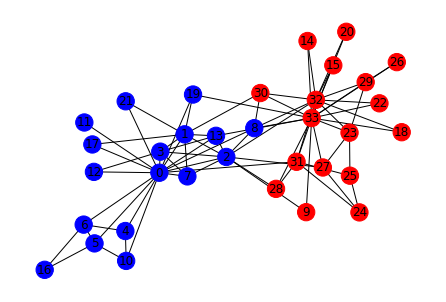

In [2]:
G = nx.karate_club_graph()
colormap = ["blue" if data["club"] == "Mr. Hi" else "red" for _, data in G.nodes(data=True)]
nx.draw(G, with_labels=True, node_color=colormap)
print("Number of nodes:", G.order())
print("Number of edges:", G.size())
print("Nodes:", G.nodes(data=True), end="\n\n")
print("Edges:", G.edges,end="\n\n")

# Edge Features

<b> Edge Classification Tasks </b>

* These tasks involve predicting new connections between nodes based on existing edges.
* At test time, all node pairs that are not yet linked are ranked, and top K node pairs are predicted.
* Must design features that represent pairs of nodes.

These tasks can be formulated in two ways:

1. Remove a random set of edges and then predict and evaluate on them.
2. Predict edges over time. Given G[t_0, t_1], a graph with edges starting from timestamp t0 up to timestamp t1, predict a ranked list L of edges that not in G[t_0, t_1] but are predicted to appear in a subsequent timestamp G[t_2, t_3].

<b>Methodology</b>

1. For each pair of nodes (x,y) compute a score c(x,y).
2. Sort pairs (x,y) by decreasing score c(x,y).
3. Predict top n pairs as new edges.
4. Verify which of these new edges actually appear at test time.

## Distance-Based Features

### Shortest-Path Distance

Counts the number of edges between the shortest path through the source and the end node. This does not capture the degere of neighborhood overlap.

In [3]:
print("Shortest path distance between node 0 and node 33:", nx.shortest_path_length(G, 0, 33))
print("Shortest path distance between the first 5 nodes and the entire graph:", list(nx.all_pairs_shortest_path_length(G))[:5])

Shortest path distance between node 0 and node 33: 2
Shortest path distance between the first 5 nodes and the entire graph: [(0, {0: 0, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 10: 1, 11: 1, 12: 1, 13: 1, 17: 1, 19: 1, 21: 1, 31: 1, 9: 2, 16: 2, 24: 2, 25: 2, 27: 2, 28: 2, 30: 2, 32: 2, 33: 2, 14: 3, 15: 3, 18: 3, 20: 3, 22: 3, 23: 3, 26: 3, 29: 3}), (1, {1: 0, 0: 1, 2: 1, 3: 1, 7: 1, 13: 1, 17: 1, 19: 1, 21: 1, 30: 1, 4: 2, 5: 2, 6: 2, 8: 2, 9: 2, 10: 2, 11: 2, 12: 2, 27: 2, 28: 2, 31: 2, 32: 2, 33: 2, 14: 3, 15: 3, 16: 3, 18: 3, 20: 3, 22: 3, 23: 3, 24: 3, 25: 3, 26: 3, 29: 3}), (2, {2: 0, 0: 1, 1: 1, 32: 1, 3: 1, 7: 1, 8: 1, 9: 1, 13: 1, 27: 1, 28: 1, 4: 2, 5: 2, 6: 2, 10: 2, 11: 2, 12: 2, 14: 2, 15: 2, 17: 2, 18: 2, 19: 2, 20: 2, 21: 2, 22: 2, 23: 2, 24: 2, 29: 2, 30: 2, 31: 2, 33: 2, 16: 3, 25: 3, 26: 3}), (3, {3: 0, 0: 1, 1: 1, 2: 1, 7: 1, 12: 1, 13: 1, 4: 2, 5: 2, 6: 2, 8: 2, 9: 2, 10: 2, 11: 2, 17: 2, 19: 2, 21: 2, 27: 2, 28: 2, 30: 2, 31: 2, 32: 2, 33: 2, 14: 3, 15: 3, 

### Local Neighborhood Overlap

Captures the number of neighboring nodes shared between two nodes u and v.

<b>Limitation:</b> these metrics are always zero if two nodes do not share any neighbors. However, the two nodes may still potentially be connected in the future.
Global neighborhood overlap solve this limitation by considering the entire graph.

In [4]:
def remove_zeros(l):  # auxiliar function
    non_zero = []
    for u, v, score in l:
        if score != 0:
            non_zero.append((u,v,score))

    return non_zero

#### Common Neighbors

Counts node intersections between neighbors of u and neighbors of v.

In [5]:
cn = []
for u in G.nodes:
    for v in G.nodes:
        if u != v:
            count_common_neighbors = len(list(nx.common_neighbors(G, u, v)))
            cn.append((u, v, count_common_neighbors))

non_zero_cn = remove_zeros(cn)

max_cn = max(cn, key=lambda x: x[2])
print(f"Biggest common neighbor score is {max_cn[2]} between node {max_cn[0]} and node {max_cn[1]}")

min_cn = min(non_zero_cn, key=lambda x: x[2])
print(f"Smallest non-zero common neighbor score is {min_cn[2]} between node {min_cn[0]} and node {min_cn[1]}")

Biggest common neighbor score is 10 between node 32 and node 33
Smallest non-zero common neighbor score is 1 between node 0 and node 8


#### Jaccard's Coefficient

Normalized version of common neighbors. Since nodes with high degree tend to have more neighbors, scale the common neighbors by the union of neighbors of u and neighbors of v.

In [6]:
jc = list(nx.jaccard_coefficient(G))
non_zero_jc = remove_zeros(jc)

max_jc = max(jc, key=lambda x: x[2])
print(f"Biggest jaccard coefficient is {max_cn[2]} between node {max_cn[0]} and node {max_cn[1]}")

min_jc = min(non_zero_jc, key=lambda x: x[2])
print(f"Smallest non-zero jaccard coefficient is {min_jc[2]} between node {min_jc[0]} and node {min_jc[1]}")

Biggest jaccard coefficient is 10 between node 32 and node 33
Smallest non-zero jaccard coefficient is 0.045454545454545456 between node 3 and node 33


#### Adamic-Adar Index

Another way of normalizing the common neighbors score. It iterates over the overlapping neighbors of u and v and sum 1/log(z) for each node z in N(u) intersection N(v). It will penalize neighbors in common that have high degree and reward neighbors in common that have low degree. Works very well in practice.

In [7]:
aai = list(nx.adamic_adar_index(G))
non_zero_aai = remove_zeros(aai)

In [8]:
max_aai = max(aai, key=lambda x: x[2])
print(f"Biggest Adamic-Adar Index is {max_aai[2]} between node {max_aai[0]} and node {max_aai[1]}")

min_aai = min(non_zero_aai, key=lambda x: x[2])
print(f"Smallest non-zero Adamic-Adar Index is {min_aai[2]} between node {min_aai[0]} and node {min_aai[1]}")

Biggest Adamic-Adar Index is 4.719381261461351 between node 2 and node 33
Smallest non-zero Adamic-Adar Index is 0.35295612386476116 between node 8 and node 26


### Global Neighborhood Overlap

#### Katz Index

Counts the number of paths of all lenghts between a given pair of nodes\*. Sums all path lengths (1 to infinity) between u and v and normalizes by a disctount factor beta (0 < beta < 1). Because of a mathematical property (geometric series of matrices), the katz index matrix is computed in closed-form: (identity - (beta * A))^-1 - identity.


\* Check the end of the notebook for an explanation on how to compute this.

In [9]:
def katz_index(G):
    # https://stackoverflow.com/questions/62069781/how-to-find-the-similarity-between-pair-of-vertices-using-katz-index-in-python

    #Calculate highest eigenvector
    L = nx.normalized_laplacian_matrix(G)
    e = np.linalg.eigvals(L.A)
    beta = 1/max(e)
    I = np.identity(len(G.nodes)) #create identity matrix

    #Katz score
    S = np.linalg.inv(I - nx.to_numpy_array(G)*beta) - I

    m, n = S.shape
    katz = [] 
    for i in range(m):
        for j in range(n):
            if i != j:
                katz.append((i, j, S[i,j]))

    return katz

ki = katz_index(G)

max_ki = max(ki, key=lambda x: x[2])
print(f"Biggest Katz Index is {max_ki[2]} between node {max_ki[0]} and node {max_ki[1]}")

min_ki = min(ki, key=lambda x: x[2])
print(f"Smallest Katz Index is {min_ki[2]} between node {min_ki[0]} and node {min_ki[1]}")

Biggest Katz Index is 1.5917451686865487 between node 21 and node 12
Smallest Katz Index is -1.8733349376202593 between node 26 and node 28


<class 'networkx.utils.decorators.argmap'> compilation 26:4: FutureWarning: normalized_laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


## Extra: Computing Lenghts of Paths Between All Nodes

Recall that given the adjacency matrix A, A[u][v] = 1 if there is a connection between u and v, while A[u][v] = 0 if there is no connection between u and v.

How to compute the number of paths of length 2 between u and v?

Accumulate the number of paths of length 1 between each node in N(u) and v. This is the same as doing summation over i in A[u][i] * A[i][v], which is matrix multiplication between A and A (A^2).

In [10]:
A = nx.adjacency_matrix(G).todense()
m, n = A.shape

count = 0
for i in range(m):
    count += A[0,i] * A[i,33]

print("Method 1: Number of paths of length 2 between 0 and 33:", count)

A_2 = np.linalg.matrix_power(A, 2)
print("Method 2: Number of paths of length 2 between 0 and 33:", A_2[0,33])

Method 1: Number of paths of length 2 between 0 and 33: 27
Method 2: Number of paths of length 2 between 0 and 33: 27


/tmp/ipykernel_571/806661315.py:1: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G).todense()


In [11]:
for i in range(1, 5):
    A_pow = np.linalg.matrix_power(A, i)
    print(f"Number of paths of length {i} between nodes 0 and 33: {A_pow[0,33]}")

Number of paths of length 1 between nodes 0 and 33: 0
Number of paths of length 2 between nodes 0 and 33: 27
Number of paths of length 3 between nodes 0 and 33: 480
Number of paths of length 4 between nodes 0 and 33: 17113
